# Human Short Promoter Classification with Genomic Pretraining and Fine Tuning

This notebook builds on the previous one by adding a fine tuning step to the genomic language model before training the classification model on the short promoter dataset. The classification model produced at the end of this notebook is the result of running the full three stage ULMFiT Process:
  1. Train a genomic language model on a large general corpus (the human genome)
  2. Fine tune the language model on the classification corpus (the promoter dataset)
  3. Train the classification model
  
The fine tuning step was absent from the E. coli notebooks because the classification corpus was small and trying to fine tune overfit the language model and reduced classification performance. The human short promoters dataset is large enough to use fine tuning. Fine tuning the language model results in significant performance gains in the classification task. Something I cannot stress enough is the best way to improve classification with this method is to improve the initial language model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

# LM Fine Tune

Here we create a language model corpus from our classification dataset. This basically concatenates all our promoter sequences into a single long string of text. The language model is trained on the concatenated promoter corpus. We need to make sure to create our dataloader with the correct vocabulary.

In [5]:
classification_df = pd.read_csv(path/'human_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,CTGTGAGTGCATACACCCTAGGTTGGGTAGGTGACCAGAGGACCTT...,1,train
1,GGGTCCGGTCGGGCGCCGCGGGGCCGTAGTTTTCGGGTCGGCGGGC...,1,train
2,GGAGTTCACTTAAGCTCTCCACCTACCTTGCTATATCTCTCCTCCC...,1,train
3,GTGAGGCGCGCGCTTGCCTGGCTAGGGTCCCTGTGAAGGAATGGGA...,1,train
4,CCCTAGGTTCTGCTCCCGACAGGCCGTCGCGGGACCGGAGCCCTCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'human_vocab.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])


In [10]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=400, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Promoter', vocab=model_vocab)

In [13]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [14]:
learn = get_model_LM(data, drop_mult, config)

We initialize the model by loading the weights from the human genome language model

In [15]:
learn.load('human_genome_full3');

In [16]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


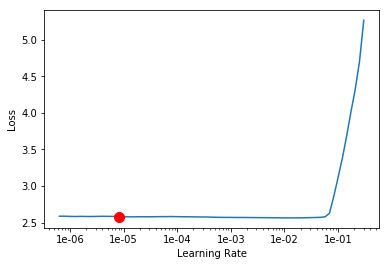

In [19]:
learn.lr_find()
learn.recorder.plot()

# Training

I was honestly surprised at how well this trained. I was able to sustain fairly high learning rates for many epochs without overfitting. The human genome language model starts out with a perplexity of ~12.6 on the promoter validation dataset, and trains down to a perplexity of ~5.57. This will provide a major boost in performance to our classification model.

In [18]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.554206,2.539521,0.197800
2,2.525255,2.494106,0.212194
3,2.464491,2.429428,0.235474
4,2.358987,2.339437,0.267690
5,2.255001,2.255480,0.298256
6,2.162021,2.190864,0.322583
7,2.084384,2.141526,0.339163
8,2.042115,2.113790,0.348903
9,2.013384,2.101763,0.353179
10,2.000770,2.099746,0.353952


In [20]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.997912,2.094339,0.355919
2,1.990592,2.078700,0.361782
3,1.971352,2.052485,0.371415
4,1.936772,2.020859,0.382121
5,1.898252,1.993187,0.391940
6,1.870003,1.969495,0.400175
7,1.837449,1.951485,0.406540
8,1.817675,1.941009,0.409962
9,1.802860,1.936631,0.411506
10,1.796945,1.935872,0.411680


In [22]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.794732,1.932975,0.412796
2,1.797306,1.924456,0.415460
3,1.789070,1.907434,0.421714
4,1.773121,1.885369,0.429252
5,1.737670,1.865946,0.436224
6,1.719105,1.847080,0.442440
7,1.696121,1.833710,0.447062
8,1.673580,1.825356,0.450224
9,1.664927,1.821853,0.451494
10,1.658929,1.821231,0.451683


In [24]:
learn.fit_one_cycle(10, 8e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.661959,1.818910,0.452454
2,1.662176,1.814400,0.454280
3,1.650141,1.805201,0.457319
4,1.643454,1.792149,0.461869
5,1.627070,1.778288,0.466496
6,1.611030,1.767022,0.470532
7,1.596964,1.758404,0.473444
8,1.579584,1.753338,0.475014
9,1.568813,1.750751,0.475948
10,1.566861,1.750364,0.476153


In [25]:
learn.save('human_LM_short_finetune')
learn.save_encoder('human_LM_short_finetune_enc')

# Classification

Now we train our standard classification model using the usual procedure. Only now we initialize with the fine tuned language model weights.

In [5]:
classification_df = pd.read_csv(path/'human_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,CTGTGAGTGCATACACCCTAGGTTGGGTAGGTGACCAGAGGACCTT...,1,train
1,GGGTCCGGTCGGGCGCCGCGGGGCCGTAGTTTTCGGGTCGGCGGGC...,1,train
2,GGAGTTCACTTAAGCTCTCCACCTACCTTGCTATATCTCTCCTCCC...,1,train
3,GTGAGGCGCGCGCTTGCCTGGCTAGGGTCCCTGTGAAGGAATGGGA...,1,train
4,CCCTAGGTTCTGCTCCCGACAGGCCGTCGCGGGACCGGAGCCCTCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'human_vocab.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)

In the config I reduced the `drop_mult` value slightly from 0.6 to 0.5. One thing I consistently see with these models is that the better your language model is, the less regularization you need in your classification model.

It appears that the quality of the language model has a strong impact on the ability of the classification model to generalize and avoid overfitting. I think this is an important point for understanding the strengths of the language model pretraining approach.

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [15]:
learn.load_encoder('human_LM_short_finetune_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04


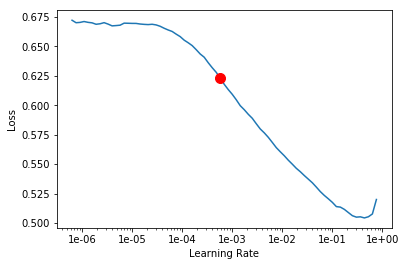

In [16]:
learn.lr_find()
learn.recorder.plot()

Right off the bat the fine tuned initialized model outperforms the final state of the previous model (with no fine tuning). Fine tuning is incredibly powerful if you have a classification corpus large enough to prevent overfitting in the fine tuning stage.

In [16]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.251623,0.262885,0.936668
2,0.228093,0.201851,0.947474
3,0.221436,0.173174,0.946469
4,0.214207,0.161721,0.950239


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.205176,0.196253,0.945966
2,0.188435,0.150052,0.953506
3,0.163747,0.136619,0.959286
4,0.149962,0.127621,0.962051


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.139308,0.131388,0.959286
2,0.129880,0.105544,0.964061
3,0.106855,0.092422,0.969088
4,0.090530,0.099599,0.967580


In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.084881,0.084549,0.972857
2,0.083746,0.075725,0.977130
3,0.067748,0.086911,0.974365
4,0.055047,0.085306,0.974617


In [21]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.051852,0.081113,0.977381
2,0.052122,0.079191,0.978889
3,0.046455,0.078451,0.979392
4,0.043002,0.075708,0.979894


In [22]:
learn.save('human_short_human_pretrain_finetune')

In [23]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

In [24]:
get_scores(learn)

Accuracy: 0.9779359430604982
False Positives: 0.017508896797153024
False Negatives: 0.004555160142348754
Recall: 0.9892219602559784
Precision: 0.9598039215686275
Specificity: 0.9696745562130178
MCC: 0.9553081960754694


The previous model (initialized with the human genome language model) achieved the following performance statistics:
  * Accuracy: .922
  * Precision: .963
  * Recall: .849
  * Specificity: .976
  * MCC: .844
  
The current model (initialized with the fine tuned language model) achieved the following:
  * Accuracy: .977
  * Precision: .959
  * Recall: .989
  * Specificity: .969
  * MCC: .955
  
That's a 29% reduction in error rate just from adding the fine tuning step.